<a href="https://colab.research.google.com/github/showalterm/do_more_with_twitter_data/blob/master/TwitterProjectCombinedFiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Overview

This file contains code that was originally run in five different segments (ipynb files). This file **will not** generate the data from the project as is, in part because the token for accessing the twitter data is not included.

Five code files are included

1.   SearchTweets10: Accesses Twitter API. Writes out the results to a json file
2.   Analysis1: Computes initial statistics for the twitter files. Runs initial sentiment analysis
3.   Analysis-WordCloud: After some cleaning, computes some Word Clouds from the extracted data.
4.   Analysis-GeoCodes: Processes the geocodes and creates maps of the data
5.   Analysis_2014-2016: Using separate runs of SearchTweets10, computes statistics for 2014 & 2016 for comparison



# SearchTweets10

This program reads tweets using the Twitter API (research access). query_str is the query string specifying elements of the search. query lists the dates over which to search, and the features to download. The result is written in JSON line format to a file (SearchTweets_10a.json). This json file can then be loaded to do sentiment and other analysis. 

3/17/2022

In [ ]:
# import the modules and function you will use here
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Colab Notebooks'


Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
!pip install searchtweets-v2

In [ ]:
import os
import pprint
import pandas as pd
import json

os.environ["SEARCHTWEETS_BEARER_TOKEN"] ="XXX"
os.environ["SEARCHTWEETS_ENDPOINT"] = "XXX"
os.environ["SEARCHTWEETS_CONSUMER_KEY"] = ""
os.environ["SEARCHTWEETS_CONSUMER_SECRET"] = ""

env_var = os.environ
  
# Print the list of user's
# environment variables
#print("User's Environment variable:")
#pprint.pprint(dict(env_var), width = 1)

In [ ]:
from searchtweets import ResultStream, gen_params_from_config, load_credentials, gen_request_parameters, collect_results

In [ ]:
v2_search_args = load_credentials("/content/gdrive/My Drive/Colab Notebooks/twitter_keys.yaml",
                                          yaml_key="search_tweets_v2",
                                          env_overwrite=False)
v2_search_args

In [ ]:
# Set up the query
query_str = '(muslim OR islam OR Muslim OR Islam) has:geo place_country:US -is:retweet -is:quote lang:en'

In [ ]:
#query = gen_request_parameters("snow", results_per_call=100,granularity="")
query = gen_request_parameters(query_str, 
                               results_per_call=500,
                               granularity="",
                               start_time= '2015-11-08',
                               end_time= '2015-11-30',
                               tweet_fields = 'author_id,created_at,geo,public_metrics,entities',
                               place_fields = 'full_name,geo,name,place_type',
                               user_fields = 'username',
                               expansions = 'author_id,geo.place_id')
                            

In [ ]:
rs = ResultStream(request_parameters=query,
                  max_tweets=100000,
                  **v2_search_args)
                  
print(rs)


ResultStream: 
	{
    "endpoint": "https://api.twitter.com/2/tweets/search/all",
    "request_parameters": {
        "query": "(muslim OR islam OR Muslim OR Islam) has:geo place_country:US -is:retweet -is:quote lang:en",
        "start_time": "2015-11-08T00:00:00Z",
        "end_time": "2015-11-30T00:00:00Z",
        "max_results": 500,
        "tweet.fields": "author_id,created_at,geo,public_metrics,entities",
        "user.fields": "username",
        "place.fields": "full_name,geo,name,place_type",
        "expansions": "author_id,geo.place_id"
    },
    "max_tweets": 100000
}


In [ ]:
tweeter=rs.stream()
type(tweeter)


generator

In [ ]:
!pip3 install twarc
from twarc import expansions

In [ ]:
file_name = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10a.json'
for page in tweeter:
   result = expansions.flatten(page)
   # We will open the file and append one JSON object per new line
   with open(file_name, 'a+') as filehandle:
       for tweet in result:
           filehandle.write('%s\n' % json.dumps(tweet))


# Analysis1

This program reads in the JSON file created by SearchTweets_10. It the computes some simple statistics and computes a sentiment score for each tweet.

3/17/2022

In [ ]:
# import the modules and function you will use here
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Colab Notebooks'

import os
import pprint
import pandas as pd
import json

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
file_name = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10a.json'


**Start here for processing data**

In [ ]:
tweets = []
with open(file_name) as f:
  for line in f:
    tweets.append(json.loads(line))

In [ ]:
tweets2 = pd.json_normalize(tweets,max_level=2)
tweets2.columns


Index(['text', 'created_at', 'id', 'author_id', 'entities.annotations',
       'entities.mentions', 'entities.urls', 'entities.hashtags',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.geo.type', 'geo.geo.bbox', 'geo.geo.properties',
       'geo.name', 'geo.id', 'geo.place_type', 'geo.full_name', 'author.id',
       'author.name', 'author.username', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'entities.cashtags',
       'withheld.copyright', 'withheld.country_codes',
       'author.withheld.country_codes'],
      dtype='object')

In [ ]:
tweets2["created_at"].head()

0    2015-11-29T23:55:02.000Z
1    2015-11-29T23:52:56.000Z
2    2015-11-29T23:51:20.000Z
3    2015-11-29T23:41:32.000Z
4    2015-11-29T23:38:09.000Z
Name: created_at, dtype: object

In [ ]:
date_time = pd.to_datetime(tweets2['created_at'])

tweets2['day']= date_time.dt.day
tweets2['month'] = date_time.dt.month
tweets2['year'] = date_time.dt.year

tweets2.head()



,text,created_at,id,author_id,entities.annotations,entities.mentions,entities.urls,entities.hashtags,public_metrics.retweet_count,public_metrics.reply_count,...,author.username,geo.coordinates.type,geo.coordinates.coordinates,entities.cashtags,withheld.copyright,withheld.country_codes,author.withheld.country_codes,day,month,year
0,"Listen to Imam Molhim's speech ""Islam Against ...",2015-11-29T23:55:02.000Z,671115179283881984,3303656672,"[{'start': 10, 'end': 20, 'probability': 0.925...","[{'start': 60, 'end': 69, 'username': 'spreake...","[{'start': 74, 'end': 97, 'url': 'https://t.co...","[{'start': 98, 'end': 120, 'tag': 'IslamAgains...",0,0,...,icmosque,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
1,Muslim Missionaries Converting Christians in A...,2015-11-29T23:52:56.000Z,671114651627843584,145576622,"[{'start': 45, 'end': 50, 'probability': 0.953...","[{'start': 111, 'end': 120, 'username': 'thebl...","[{'start': 83, 'end': 106, 'url': 'https://t.c...",NaN,0,0,...,wryan31,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
2,@TuckOnTheRise some religions embrace spiritua...,2015-11-29T23:51:20.000Z,671114249385611264,35478824,NaN,NaN,NaN,NaN,0,0,...,AppleciderPapi,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
3,@albertmohler #TheBriefing podcast Nov 16-7-18...,2015-11-29T23:41:32.000Z,671111783189360640,21106876,"[{'start': 64, 'end': 68, 'probability': 0.308...","[{'start': 0, 'end': 13, 'username': 'albertmo...","[{'start': 114, 'end': 137, 'url': 'https://t....","[{'start': 14, 'end': 26, 'tag': 'TheBriefing'}]",0,0,...,mlaneharrison,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
4,Didn't know the amount of makeup I wore determ...,2015-11-29T23:38:09.000Z,671110930424602624,1311248862,"[{'start': 54, 'end': 57, 'probability': 0.641...",NaN,NaN,"[{'start': 94, 'end': 119, 'tag': 'NotYourResp...",41,1,...,palestyria,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015


In [ ]:
countem=tweets2.loc[:,['day','text']]


In [ ]:
testit2 = countem.groupby('day').count()
print(testit2)

     text
day      
8     131
9     176
10    158
11    203
12    164
13    520
14   2387
15   1208
16   1239
17   1131
18   1060
19    795
20    981
21    788
22    631
23    546
24    505
25    405
26    323
27    274
28    372
29    306


In [ ]:
# spaCy is a library to do cleaning, tqdm allows for some handing extensions to
# dataframes (progress_apply)

import spacy
from tqdm import tqdm

tqdm.pandas()


nlp = spacy.load('en_core_web_sm')

def cleaner(string):
    
    # Generate list of tokens
    doc = nlp(string)
    lemmas = [token.lemma_ for token in doc]

    # Remove tokens that are not alphabetic 
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() 
                 or lemma == '-PRON-'] 

    # Print string after text cleaning
    return ' '.join(a_lemmas)

In [ ]:
tweets2['text_cleaned'] = tweets2['text'].progress_apply(cleaner)

100%|██████████| 14303/14303 [02:33<00:00, 92.96it/s]


In [ ]:
!pip install nltk
!pip install twython

In [ ]:
# Extract pos/neg/neutral
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

df_sentiment = tweets2.copy()

# instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentiment_scores = df_sentiment['text'].progress_apply(
                                                       sid.polarity_scores)
df_sentiment['sc_compound'] = sentiment_scores.apply(lambda x: x['compound'])
df_sentiment['sc_negative'] = sentiment_scores.apply(lambda x: x['neg'])
df_sentiment['sc_neutral']  = sentiment_scores.apply(lambda x: x['neu'])
df_sentiment['sc_positive'] = sentiment_scores.apply(lambda x: x['pos'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|██████████| 14303/14303 [00:11<00:00, 1258.29it/s]


In [ ]:
# continue 
df_sentiment.loc[:,['sc_compound','sc_positive','sc_negative','sc_neutral']]

,sc_compound,sc_positive,sc_negative,sc_neutral
0,-0.6808,0.000,0.277,0.723
1,0.0000,0.000,0.000,1.000
2,0.5859,0.202,0.000,0.798
3,0.2023,0.164,0.128,0.708
4,0.6486,0.261,0.000,0.739
...,...,...,...,...
14298,0.3716,0.104,0.000,0.896
14299,-0.2732,0.133,0.200,0.667
14300,0.6249,0.362,0.000,0.638
14301,-0.6908,0.000,0.266,0.734


In [ ]:
# continue 
df_sentiment['ss_positive'] = df_sentiment['sc_compound'].apply(
    lambda c: 1 if c >=0 else 0)
df_sentiment['ss_negative'] = df_sentiment['sc_compound'].apply(
    lambda c: -1 if c < 0 else 0)
sentiment_sum = df_sentiment.loc[:,['day','sc_compound','sc_positive','sc_negative',
                                    'sc_neutral','ss_positive','ss_negative']]

testit=sentiment_sum.groupby('day').sum(['ss_positive','ss_negative'])
print(testit)

     sc_compound  sc_positive  sc_negative  sc_neutral  ss_positive  \
day                                                                   
8        -1.8647       12.450       12.456     106.098           82   
9        -6.9680       15.251       16.918     143.832          110   
10      -22.4284       12.108       19.995     125.897           83   
11      -13.4534       19.579       23.557     159.863          117   
12       -9.8365       12.919       14.876     136.202           98   
13     -107.2452       40.726       80.328     398.942          254   
14     -564.8959      209.599      419.015    1758.364          977   
15     -193.7116      104.974      173.792     929.229          580   
16     -196.4193      100.749      173.163     965.070          618   
17     -160.9427      101.789      155.600     873.620          580   
18     -189.2480       85.961      150.897     823.141          490   
19      -84.5334       73.901      108.380     612.725          425   
20    

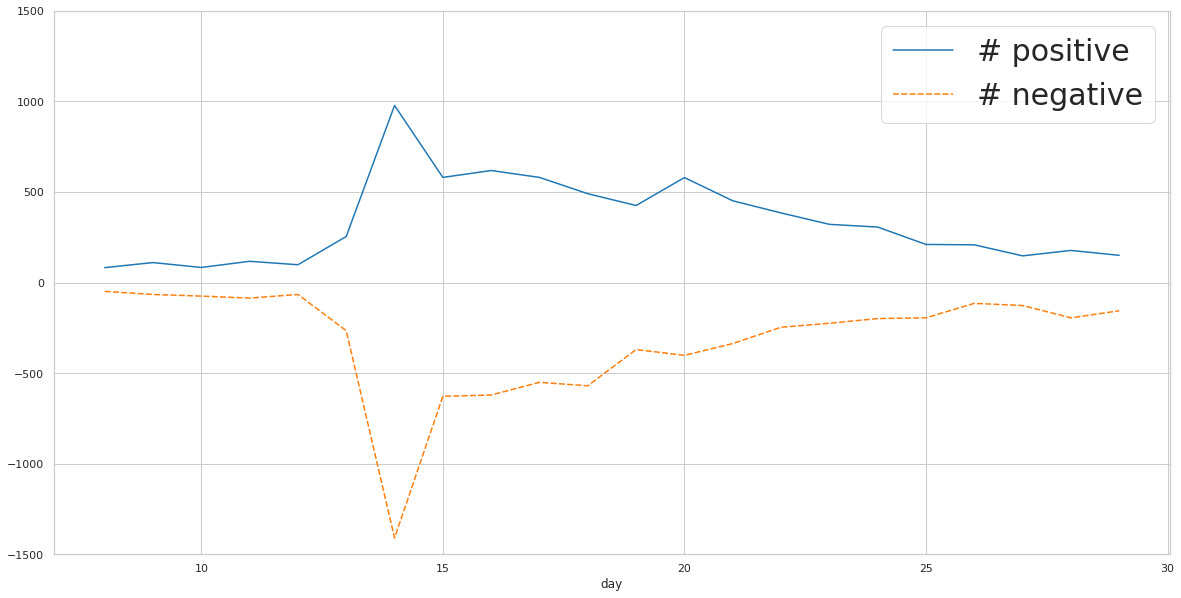

In [ ]:
from matplotlib.font_manager import FontProperties
graph_data = testit.loc[:,['ss_positive','ss_negative']]
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (20, 10)
plt.ylim(-1500,1500)
plt.rc('legend', fontsize=100)

sns.set_theme(style="whitegrid")
sns.lineplot(data=graph_data, palette="tab10")
plt.legend(labels=['# positive', '# negative'], fontsize=30)

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

df_sentiment = tweets2.copy()

# instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentiment_scores1 = df_sentiment['text_cleaned'].progress_apply(
                                                            sid.polarity_scores)
sentiment1 = sentiment_scores1.apply(lambda x: x['compound'])
df_sentiment['sentiment1'] = sentiment1

sentiment_scores2 = df_sentiment['text'].progress_apply(
                                                            sid.polarity_scores)
sentiment2 = sentiment_scores2.apply(lambda x: x['compound'])
df_sentiment['sentiment2'] = sentiment2


In [ ]:
df_sentiment[['day','text','text_cleaned','sentiment1','sentiment2']]

,day,text,text_cleaned,sentiment1,sentiment2
0,29,"Listen to Imam Molhim's speech ""Islam Against ...",listen to Imam Molhim speech Islam Against Ter...,-0.6808,-0.6808
1,29,Muslim Missionaries Converting Christians in A...,Muslim Missionaries convert Christians in Afri...,0.0000,0.0000
2,29,@TuckOnTheRise some religions embrace spiritua...,some religion embrace spiritually while some f...,0.5859,0.5859
3,29,@albertmohler #TheBriefing podcast Nov 16-7-18...,TheBriefing podcast Nov be excellent on Islam ...,0.1531,0.2023
4,29,Didn't know the amount of makeup I wore determ...,do not know the amount of makeup -PRON- wear d...,0.4404,0.6486
...,...,...,...,...,...
14298,8,@VTXSILVERWOLF @_Ash_Bell__ if we didn't have ...,if -PRON- do not have the Liberals Radical Isl...,0.1603,0.3716
14299,8,@DunstanMJ black liberation theology is a cous...,black liberation theology be a cousin to black...,-0.6908,-0.2732
14300,8,🐚🐚 Hey you nice cool and a real Muslim hmu you...,hey -PRON- nice cool and a real muslim hmu -PR...,0.6249,0.6249
14301,8,"@teriobrien It's rape jihad. After all, they ...",-PRON- be rape jihad after all -PRON- believe ...,-0.6908,-0.6908


In [ ]:
df_sentiment.to_csv('/content/gdrive/My Drive/Colab Notebooks/Analysis1a.csv')

In [ ]:
testit3=df_sentiment.groupby('day').mean()
print(testit3)

     public_metrics.retweet_count  public_metrics.reply_count  \
day                                                             
8                        0.496183                    0.183206   
9                        0.642045                    0.414773   
10                       0.594937                    0.329114   
11                       1.926108                    0.344828   
12                       0.981707                    0.567073   
13                       0.830769                    0.325000   
14                       1.969418                    0.499791   
15                       1.582781                    0.541391   
16                       2.491525                    0.390638   
17                       0.749779                    0.335102   
18                       1.123585                    0.323585   
19                       1.045283                    0.338365   
20                       1.257900                    0.443425   
21                       

# Analysis-WordCloud

This program reads in the JSON file created by SearchTweets_10. It the computes some simple statistics and computes a sentiment score for each tweet.

3/17/2022

In [ ]:
# import the modules and function you will use here
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Colab Notebooks'

import os
import pprint
import pandas as pd
import json

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
file_name = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10a.json'


**Start here for processing data**

In [ ]:
tweets = []
with open(file_name) as f:
  for line in f:
    tweets.append(json.loads(line))

In [ ]:
tweets2 = pd.json_normalize(tweets,max_level=2)
tweets2.columns


Index(['text', 'created_at', 'id', 'author_id', 'entities.annotations',
       'entities.mentions', 'entities.urls', 'entities.hashtags',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.geo.type', 'geo.geo.bbox', 'geo.geo.properties',
       'geo.name', 'geo.id', 'geo.place_type', 'geo.full_name', 'author.id',
       'author.name', 'author.username', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'entities.cashtags',
       'withheld.copyright', 'withheld.country_codes',
       'author.withheld.country_codes'],
      dtype='object')

In [ ]:
tweets2["created_at"].head()

0    2015-11-29T23:55:02.000Z
1    2015-11-29T23:52:56.000Z
2    2015-11-29T23:51:20.000Z
3    2015-11-29T23:41:32.000Z
4    2015-11-29T23:38:09.000Z
Name: created_at, dtype: object

In [ ]:
date_time = pd.to_datetime(tweets2['created_at'])

tweets2['day']= date_time.dt.day
tweets2['month'] = date_time.dt.month
tweets2['year'] = date_time.dt.year

tweets2.head()



,text,created_at,id,author_id,entities.annotations,entities.mentions,entities.urls,entities.hashtags,public_metrics.retweet_count,public_metrics.reply_count,...,author.username,geo.coordinates.type,geo.coordinates.coordinates,entities.cashtags,withheld.copyright,withheld.country_codes,author.withheld.country_codes,day,month,year
0,"Listen to Imam Molhim's speech ""Islam Against ...",2015-11-29T23:55:02.000Z,671115179283881984,3303656672,"[{'start': 10, 'end': 20, 'probability': 0.925...","[{'start': 60, 'end': 69, 'username': 'spreake...","[{'start': 74, 'end': 97, 'url': 'https://t.co...","[{'start': 98, 'end': 120, 'tag': 'IslamAgains...",0,0,...,icmosque,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
1,Muslim Missionaries Converting Christians in A...,2015-11-29T23:52:56.000Z,671114651627843584,145576622,"[{'start': 45, 'end': 50, 'probability': 0.953...","[{'start': 111, 'end': 120, 'username': 'thebl...","[{'start': 83, 'end': 106, 'url': 'https://t.c...",NaN,0,0,...,wryan31,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
2,@TuckOnTheRise some religions embrace spiritua...,2015-11-29T23:51:20.000Z,671114249385611264,35478824,NaN,NaN,NaN,NaN,0,0,...,AppleciderPapi,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
3,@albertmohler #TheBriefing podcast Nov 16-7-18...,2015-11-29T23:41:32.000Z,671111783189360640,21106876,"[{'start': 64, 'end': 68, 'probability': 0.308...","[{'start': 0, 'end': 13, 'username': 'albertmo...","[{'start': 114, 'end': 137, 'url': 'https://t....","[{'start': 14, 'end': 26, 'tag': 'TheBriefing'}]",0,0,...,mlaneharrison,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015
4,Didn't know the amount of makeup I wore determ...,2015-11-29T23:38:09.000Z,671110930424602624,1311248862,"[{'start': 54, 'end': 57, 'probability': 0.641...",NaN,NaN,"[{'start': 94, 'end': 119, 'tag': 'NotYourResp...",41,1,...,palestyria,NaN,NaN,NaN,NaN,NaN,NaN,29,11,2015


In [ ]:
countem=tweets2.loc[:,['day','text']]


In [ ]:
testit2 = countem.groupby('day').count()
print(testit2)

     text
day      
8     131
9     176
10    158
11    203
12    164
13    520
14   2387
15   1208
16   1239
17   1131
18   1060
19    795
20    981
21    788
22    631
23    546
24    505
25    405
26    323
27    274
28    372
29    306


In [ ]:
# spaCy is a library to do cleaning, tqdm allows for some handling extensions to
# dataframes (progress_apply)

import spacy
from tqdm import tqdm

tqdm.pandas()


nlp = spacy.load('en_core_web_sm')

def cleaner(string):
    
    # Generate list of tokens
    doc = nlp(string)
    lemmas = [token.lemma_ for token in doc]
    
    # Remove tokens that are not alphabetic 
#    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() 
#                 or lemma == '-PRON-'] 
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha()]
                 

    # Print string after text cleaning
    return ' '.join(a_lemmas)

In [ ]:
tweets2['text_cleaned'] = tweets2['text'].progress_apply(cleaner)

100%|██████████| 14303/14303 [03:05<00:00, 76.92it/s]


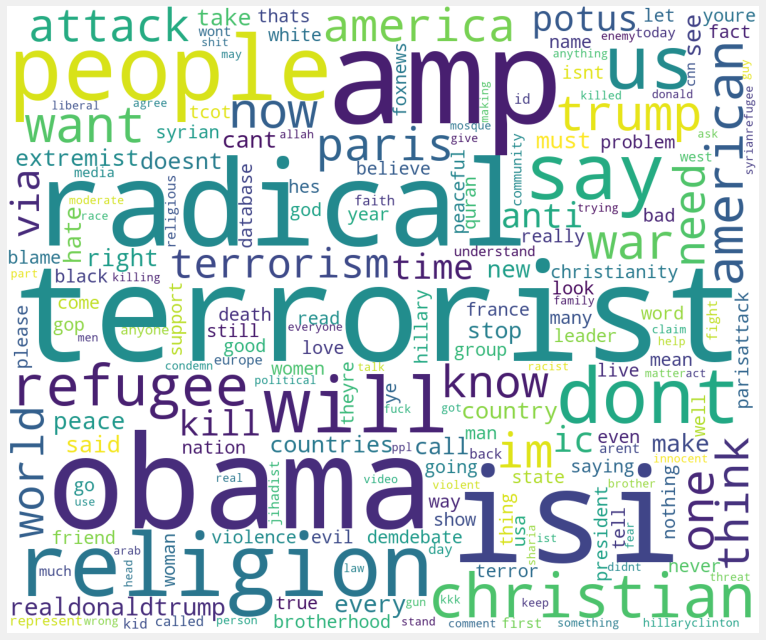

In [ ]:
# Creating word clouds. This section uses pre & post
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (20, 10)
plt.figure(figsize=(12,12))

bigstring = tweets2['text'].str.cat(sep=' ')
bigstring2 = "".join([i.lower() for i in bigstring if i not in string.punctuation])
bigstring4 = bigstring2.replace('muslim','')
bigstring5 = bigstring4.replace('islam','')

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring5)
plt.axis('off')
plt.imshow(wordcloud)




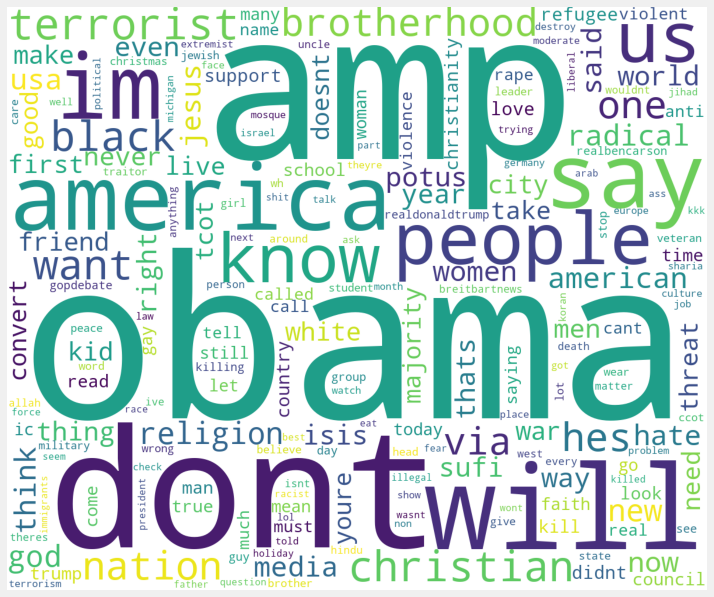

In [ ]:
# This section creates the word cloud prior to the attack

tweets2_before = tweets2.loc[tweets2['day'] <= 12]
bigstring = tweets2_before['text'].str.cat(sep=' ')
bigstring2 = "".join([i.lower() for i in bigstring if i not in string.punctuation])
bigstring4 = bigstring2.replace('muslim','')
bigstring5 = bigstring4.replace('islam','')

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring5)
plt.axis('off')
plt.imshow(wordcloud)



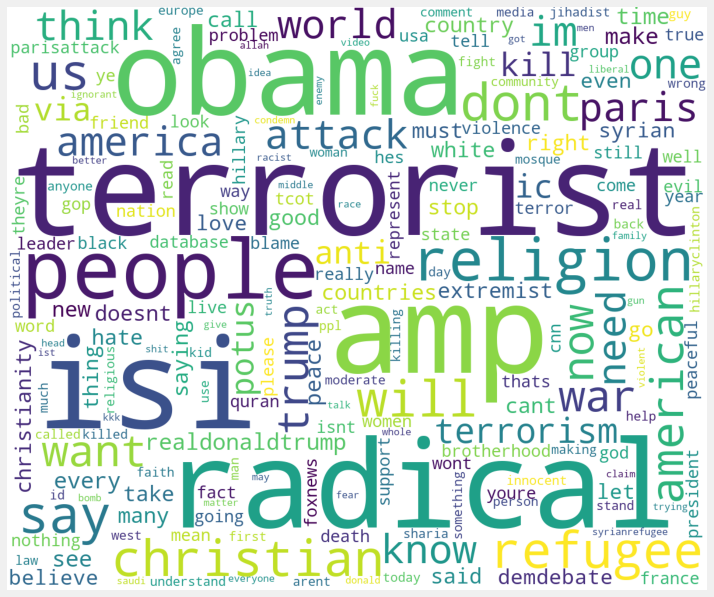

In [ ]:
# This section creates the word cloud after to the attack

tweets2_after = tweets2.loc[tweets2['day'] >= 14]
bigstring = tweets2_after['text'].str.cat(sep=' ')
bigstring2 = "".join([i.lower() for i in bigstring if i not in string.punctuation])
bigstring4 = bigstring2.replace('muslim','')
bigstring5 = bigstring4.replace('islam','')

wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          collocations=False,
                          width=1200,
                          height=1000
                         ).generate(bigstring5)
plt.axis('off')
plt.imshow(wordcloud)



# Analysis-GeoCodes

This program reads in the JSON file created by SearchTweets_10. It explores the geo coding of the tweets.

3/31/2022

See copy-intro_cartopy.ipynb for code to do mapping. 4/2/2022

In [ ]:
!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip3 install cython
!pip3 install cartopy

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (92.7 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 156210 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

In [ ]:
!apt-get -qq install python-cartopy python3-cartopy
!pip uninstall -y shapely    # cartopy and shapely aren't friends (early 2020)
!pip install shapely --no-binary shapely

Selecting previously unselected package python-pkg-resources.
(Reading database ... 156226 files and directories currently installed.)
Preparing to unpack .../00-python-pkg-resources_39.0.1-2_all.deb ...
Unpacking python-pkg-resources (39.0.1-2) ...
Selecting previously unselected package python-pyshp.
Preparing to unpack .../01-python-pyshp_1.2.12+ds-1_all.deb ...
Unpacking python-pyshp (1.2.12+ds-1) ...
Selecting previously unselected package python-shapely.
Preparing to unpack .../02-python-shapely_1.6.4-1_amd64.deb ...
Unpacking python-shapely (1.6.4-1) ...
Selecting previously unselected package python-six.
Preparing to unpack .../03-python-six_1.11.0-2_all.deb ...
Unpacking python-six (1.11.0-2) ...
Selecting previously unselected package python-cartopy:amd64.
Preparing to unpack .../04-python-cartopy_0.14.2+dfsg1-2build3_amd64.deb ...
Unpacking python-cartopy:amd64 (0.14.2+dfsg1-2build3) ...
Selecting previously unselected package python3-numpy.
Preparing to unpack .../05-python

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np

import cartopy
import cartopy.crs as ccrs                   # for projections
import cartopy.feature as cfeature           # for features
import cartopy.io.shapereader as shapereader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.feature.nightshade import Nightshade

In [ ]:
# import the modules and function you will use here
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Colab Notebooks'

import os
import pprint
import pandas as pd
import json

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks


In [ ]:
file_name = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10a.json'


**Start here for processing data**

In [ ]:
tweets = []
with open(file_name) as f:
  for line in f:
    tweets.append(json.loads(line))

In [ ]:
tweets2 = pd.json_normalize(tweets,max_level=2)
tweets2.columns


Index(['text', 'created_at', 'id', 'author_id', 'entities.annotations',
       'entities.mentions', 'entities.urls', 'entities.hashtags',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.geo.type', 'geo.geo.bbox', 'geo.geo.properties',
       'geo.name', 'geo.id', 'geo.place_type', 'geo.full_name', 'author.id',
       'author.name', 'author.username', 'geo.coordinates.type',
       'geo.coordinates.coordinates', 'entities.cashtags',
       'withheld.copyright', 'withheld.country_codes',
       'author.withheld.country_codes'],
      dtype='object')

In [ ]:
testit = tweets2.columns[[x.startswith("geo") for x in tweets2.columns]]
testit3 = tweets2.loc[:,testit]
testit3.head()


In [ ]:
# the isinstance line catches missing values for lat/long
# find centroid based on bbox

testit4 = testit3.loc[:,'geo.geo.bbox']
#lat1 = testit4.loc[0][3]
lat1 = []
lon1 = []
#for row in testit4.iteritems():
#  lat1.append(testit4.loc[index][0])
for row, value in enumerate(testit4):
  if isinstance(testit4.loc[row], list):
    lon1.append((testit4.loc[row][0]+testit4.loc[row][2])/2)
    lat1.append((testit4.loc[row][1]+testit4.loc[row][3])/2)
  else:
    lat1.append(0)
    lon1.append(0)


lat1p = pd.DataFrame(lat1)
lon1p = pd.DataFrame(lon1)

In [ ]:
# Create variable that gives lat and long for observations that have it
# The above code works off the geo box. This will replace it.

testit4a = testit3.loc[:,'geo.coordinates.coordinates']
lat1 = []
lon1 = []
for row, value in enumerate(testit4a):
  if isinstance(testit4a.loc[row], list):
    lat1.append((testit4a.loc[row][1]))
    lon1.append((testit4a.loc[row][0]))
  else:
    lat1.append(0)
    lon1.append(0)

lat1pp = pd.DataFrame(lat1)
lon1pp = pd.DataFrame(lon1)
latlon1 = pd.concat([lat1pp, lon1pp], axis=1)
my_columns2 = ["latp", "lonp"]
latlon1.columns = my_columns2

In [ ]:
testit5 = pd.concat([lat1p, lon1p], axis=1)
my_columns = ["lat", "lon"]
testit5.columns = my_columns

testit6=pd.concat([testit3,testit5], axis=1)
# recode Florida state observations lat=29.3, lon=-82.0
testit6.loc[testit6['geo.name'] == "Florida", 'lat'] = 29.3
testit6.loc[testit6['geo.name'] == "Florida", 'lon'] = -82.0

# The following merges in the exact lat/lon for observations that have it
# and then replace any values that were estimated with the box with 
# the exact coordinates
testit6a=pd.concat([testit6,latlon1], axis=1)

testit6a['lat'].mask(testit6a['latp'] !=0, testit6a['latp'], inplace=True)
testit6a['lon'].mask(testit6a['lonp'] !=0, testit6a['lonp'], inplace=True)

testit6a.drop(columns=['latp','lonp'], inplace=True)


the bbox codes must be edges of a geographic area. Note the size of the box based on state versus city. So, a reasonable way to code location would be to average the two latide numbers, +/- 0.5 around the mean. same for longitude. That will give standardized small boxes. Feed into a heat map generator. 

Using info from this web site: https://medium.com/analytics-vidhya/exploring-twitter-data-using-python-part-iii-analyzing-the-data-e883aa340dff

In [ ]:
# select obs with lat & long
testit7 = testit6a.loc[testit6a['lat']!=0]
testit8 = pd.DataFrame(testit7.groupby(['lat','lon']).count())
testit9 = pd.DataFrame(testit8['geo.geo.bbox'])
testit9.reset_index(inplace=True)
testit9.rename(columns={'geo.geo.bbox':'count_tweets'}, inplace=True)
testit9.head()






,lat,lon,count_tweets
0,9.570561,44.067733,1
1,13.418300,144.664739,1
2,18.199755,-66.583628,4
3,18.346521,-64.950493,2
4,18.384166,-66.058368,1


In [ ]:
testit9.describe()

,lat,lon,count_tweets
count,2768.000000,2768.000000,2768.000000
mean,37.876583,-89.834412,4.960621
std,5.347812,17.922310,17.601117
min,9.570561,-166.599693,1.000000
25%,34.054718,-96.960118,1.000000
50%,39.008106,-84.272484,1.000000
75%,41.369552,-76.919310,3.000000
max,64.838086,144.664739,301.000000


In [ ]:
#import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (20, 10)




In [ ]:
#!pip install cartopy
#import cartopy

#import cartopy.crs as ccrs
from matplotlib.patches import Circle


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


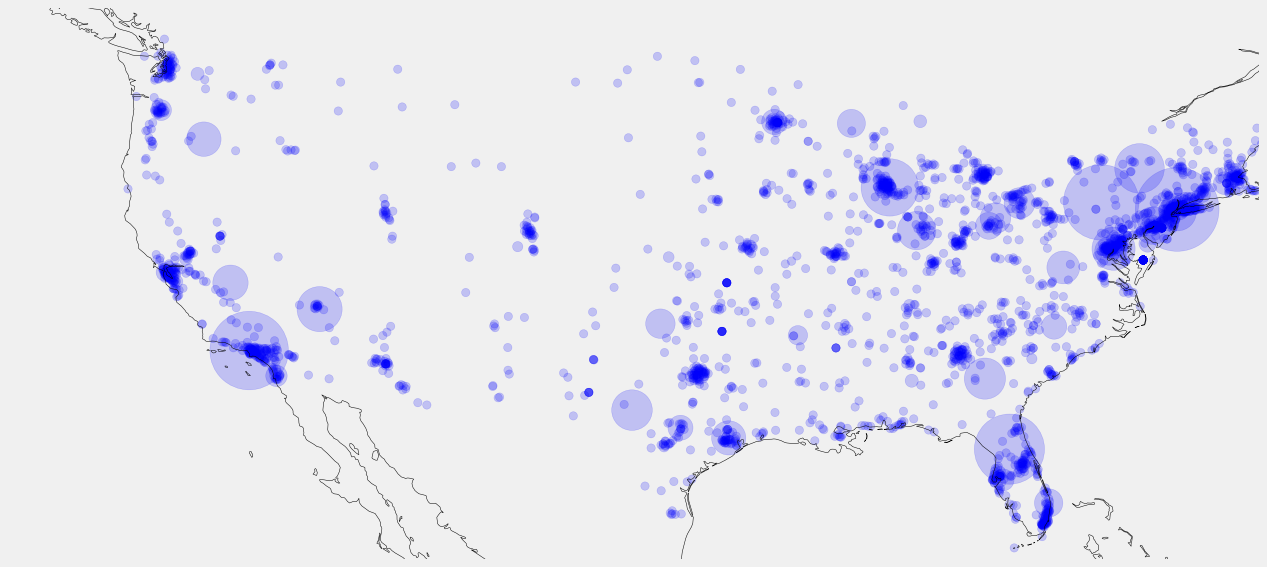

In [ ]:
ax = plt.axes(projection=ccrs.PlateCarree())
#ax.stock_img()
# plot individual locations                                                                                                       
#ax.plot(testit9.lon, testit9.lat, 'ro', transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')
ax.set_global()
ax.set_extent([-130, -70, 24, 50.5], crs=ccrs.PlateCarree())

# test section


# end test section

for index, row in testit9.iterrows():
  tradius = max(row['count_tweets']/150,.2)
  ax.add_patch(Circle(xy=[row['lon'], row['lat']], radius=tradius, color='blue', 
                    alpha=0.2,
                    transform=ccrs.PlateCarree()))

plt.show()




/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


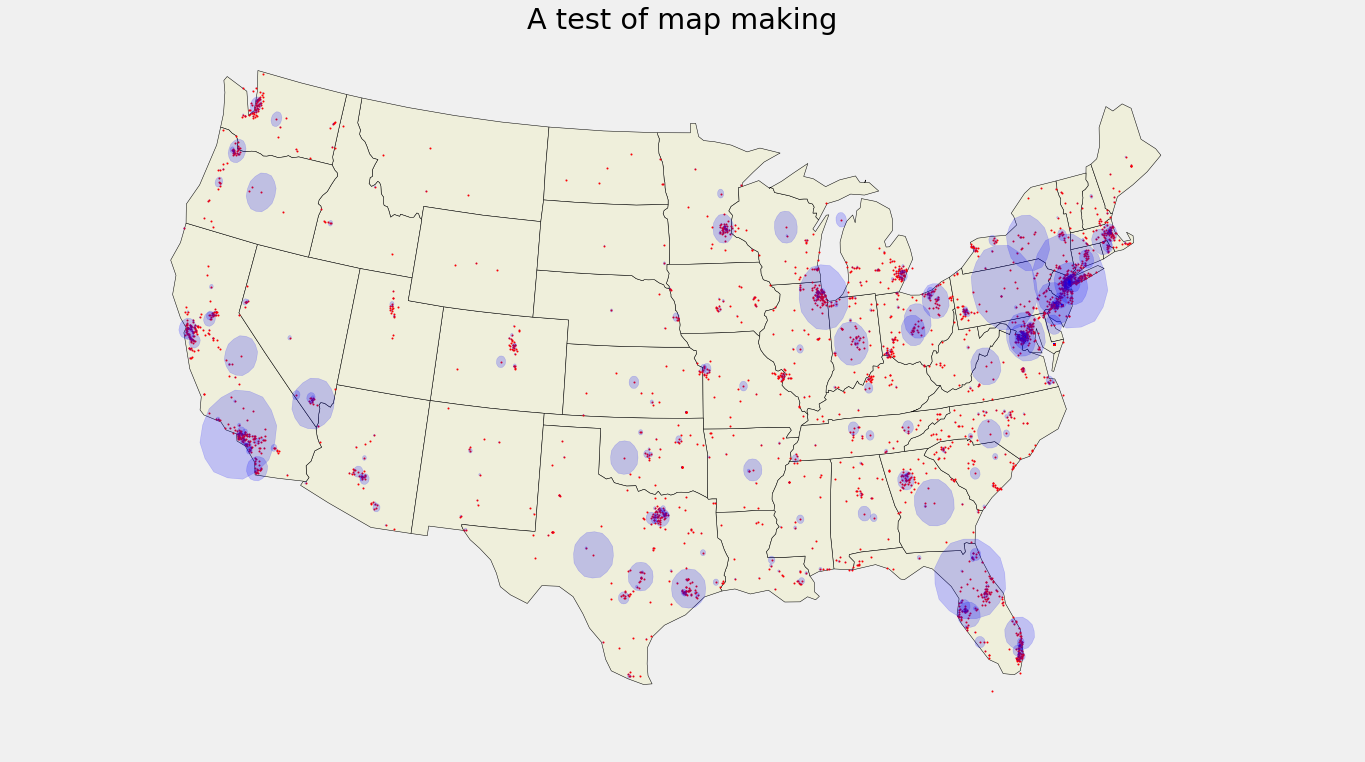

In [ ]:
# This cell is testing code for alternative maps
import shapely.geometry as sgeom
import cartopy.io.shapereader as shpreader
def sample_data():
    lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0,
            -79.6, -80.1, -80.3, -81.3, -82.0, -82.6, -83.3, -84.0,
            -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, -89.2, -89.6,
            -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0,
            -85.3, -82.9]

    lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0,
            25.9, 25.4, 25.1, 24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2,
            25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 30.2, 31.1, 32.6, 34.1,
            35.6, 37.0, 38.6, 40.1]

    return lons, lats


fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(),
                  frameon=False)
ax.patch.set_visible(False)


ax.set_extent([-125, -66.5, 20, 50], ccrs.Geodetic())

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m',
                                     category='cultural',
                                     name=shapename)

lons, lats = sample_data()

ax.set_title('A test of map making')

# turn the lons and lats into a shapely LineString
track = sgeom.LineString(zip(lons, lats))

# buffer the linestring by two degrees (note: this is a non-physical
# distance)
track_buffer = track.buffer(2)

#def colorize_state(geometry):
#    facecolor = (0.9375, 0.9375, 0.859375)
#    if geometry.intersects(track):
#       facecolor = 'red'
#    elif geometry.intersects(track_buffer):
#         facecolor = '#FF7E00'
#    return {'facecolor': facecolor, 'edgecolor': 'black'}

def colorize_state(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    if geometry.intersects(track):
       facecolor = (0.9375, 0.9375, 0.859375)
    elif geometry.intersects(track_buffer):
         facecolor = (0.9375, 0.9375, 0.859375)
    return {'facecolor': facecolor, 'edgecolor': 'black'}

ax.add_geometries(
    shpreader.Reader(states_shp).geometries(),
    ccrs.PlateCarree(),
    styler=colorize_state
    )

# plot individual locations                                                                                                       
ax.plot(testit9.lon, testit9.lat, 'ro',
        markersize =1,
        transform=ccrs.PlateCarree())

for index, row in testit9.iterrows():
  ax.add_patch(Circle(xy=[row['lon'], row['lat']], 
                      radius=row['count_tweets']/150, 
                      color='blue', 
                      alpha=0.2,
                      zorder=3,
                      transform=ccrs.PlateCarree()))
plt.show()




# Analysis_2014-2016

In [ ]:
# import the modules and function you will use here
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/My Drive/Colab Notebooks'

import os
import pprint
import pandas as pd
import json

!pip install nltk
!pip install twython

In [ ]:
file_name_2014 = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10_2014.json'
file_name_2015 = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10a.json'
file_name_2016 = '/content/gdrive/My Drive/Colab Notebooks/searchtweets_10_2016.json'


**Start here for processing data**

Ran three times, first with file_name_2015, then with 2014, then with 2016

In [ ]:
tweets = []
with open(file_name_2016) as f:
  for line in f:
    tweets.append(json.loads(line))

tweets2 = pd.json_normalize(tweets,max_level=2)

date_time = pd.to_datetime(tweets2['created_at'])

tweets2['day']= date_time.dt.day
tweets2['month'] = date_time.dt.month
tweets2['year'] = date_time.dt.year

countem=tweets2.loc[:,['day','text']]

testit2 = countem.groupby('day').count()
print(testit2)


     text
day      
8     243
9    1638
10    749
11    615
12    422
13    392
14    352
15    293
16    473
17    610
18    662
19    447
20    455
21    402
22    312
23    216
24    241
25    176
26    181
27    187
28    429
29    528


In [ ]:
# Not sure this is needed in this program. Carryover code
# spaCy is a library to do cleaning, tqdm allows for some handing extensions to
# dataframes (progress_apply)

import spacy
from tqdm import tqdm

tqdm.pandas()

nlp = spacy.load('en_core_web_sm')

def cleaner(string):
    
    # Generate list of tokens
    doc = nlp(string)
    lemmas = [token.lemma_ for token in doc]

    # Remove tokens that are not alphabetic 
    a_lemmas = [lemma for lemma in lemmas if lemma.isalpha() 
                 or lemma == '-PRON-'] 

    # Print string after text cleaning
    return ' '.join(a_lemmas)

In [ ]:
# Extract pos/neg/neutral
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

df_sentiment = tweets2.copy()

# instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

sentiment_scores = df_sentiment['text'].progress_apply(
                                                       sid.polarity_scores)
df_sentiment['sc_compound'] = sentiment_scores.apply(lambda x: x['compound'])
df_sentiment['sc_negative'] = sentiment_scores.apply(lambda x: x['neg'])
df_sentiment['sc_neutral']  = sentiment_scores.apply(lambda x: x['neu'])
df_sentiment['sc_positive'] = sentiment_scores.apply(lambda x: x['pos'])

df_sentiment['ss_positive'] = df_sentiment['sc_compound'].apply(
    lambda c: 1 if c >=0 else 0)
df_sentiment['ss_negative'] = df_sentiment['sc_compound'].apply(
    lambda c: -1 if c < 0 else 0)
sentiment_sum = df_sentiment.loc[:,['day','sc_compound','sc_positive','sc_negative',
                                    'sc_neutral','ss_positive','ss_negative']]

testit=sentiment_sum.groupby('day').sum(['ss_positive','ss_negative'])



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


100%|██████████| 10023/10023 [00:03<00:00, 3190.66it/s]


In [ ]:
# continue 
df_sentiment['ss_positive'] = df_sentiment['sc_compound'].apply(
    lambda c: 1 if c >=0 else 0)
df_sentiment['ss_negative'] = df_sentiment['sc_compound'].apply(
    lambda c: -1 if c < 0 else 0)
sentiment_sum = df_sentiment.loc[:,['day','sc_compound','sc_positive','sc_negative',
                                    'sc_neutral','ss_positive','ss_negative']]

testit=sentiment_sum.groupby('day').sum(['ss_positive','ss_negative'])
print(testit)

     sc_compound  sc_positive  sc_negative  sc_neutral  ss_positive  \
day                                                                   
8         3.5179       23.520       23.022     196.457          157   
9        59.1650      211.145      184.922    1241.947          984   
10      -50.5727       69.766       85.580     593.665          422   
11      -49.7587       59.312       76.788     478.891          340   
12      -23.4477       38.370       45.000     338.622          251   
13      -31.1388       34.437       45.267     312.293          219   
14      -26.4557       31.635       39.528     280.833          195   
15      -37.6466       23.951       36.428     232.599          132   
16      -35.7744       37.900       50.277     384.829          280   
17      -37.3523       48.577       58.619     502.796          381   
18      -24.3152       56.483       60.723     544.794          407   
19      -38.5363       35.622       50.366     361.010          256   
20    

Quick cheat: Run the above section of code once for each of the three years. Save the output into CSV file. Combine them in excel. Read them back in as a single file, then graph. It would be possible to do it all in python, but it would take longer to figure out the code. (4/12/2022)

In [ ]:
graph_data_15 = testit.loc[:,["ss_positive","ss_negative"]]
graph_data_15.rename(columns={"ss_positive": "ss_pos_15","ss_negative": "ss_neg_15"},inplace=True)
graph_data_15.head()

,ss_pos_15,ss_neg_15
day,,
8,82,-49
9,110,-66
10,83,-75
11,117,-86
12,98,-66


In [ ]:
graph_data_14 = testit.loc[:,["ss_positive","ss_negative"]]
graph_data_14.rename(columns={"ss_positive": "ss_pos_14","ss_negative": "ss_neg_14"},inplace=True)
graph_data_14.head()

,ss_pos_14,ss_neg_14
day,,
8,95,-56
9,61,-26
10,75,-55
11,86,-31
12,72,-49


In [ ]:
graph_data_16 = testit.loc[:,["ss_positive","ss_negative"]]
graph_data_16.rename(columns={"ss_positive": "ss_pos_16","ss_negative": "ss_neg_16"},inplace=True)
graph_data_16.head()

,ss_pos_16,ss_neg_16
day,,
8,157,-86
9,984,-654
10,422,-327
11,340,-275
12,251,-171


In [ ]:
graph_data = pd.concat([graph_data_14, graph_data_15, graph_data_16], axis=1)
gd_14_15 = graph_data[['ss_pos_14','ss_neg_14','ss_pos_15','ss_neg_15']]
gd_15_16 = graph_data[['ss_pos_15','ss_neg_15','ss_pos_16','ss_neg_16']]
gd_15_16.head()

,ss_pos_15,ss_neg_15,ss_pos_16,ss_neg_16
day,,,,
8,82,-49,157,-86
9,110,-66,984,-654
10,83,-75,422,-327
11,117,-86,340,-275
12,98,-66,251,-171


In [ ]:
# Graph all three years--It's a mess
from matplotlib.font_manager import FontProperties
#graph_data = testit.loc[:,['ss_positive','ss_negative']]
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (20, 10)
plt.ylim(-1500,1500)
plt.rc('legend', fontsize=100)

sns.set_theme(style="whitegrid")
sns.lineplot(data=graph_data, palette="tab10")
#plt.legend(labels=['# positive', '# negative'], fontsize=30)

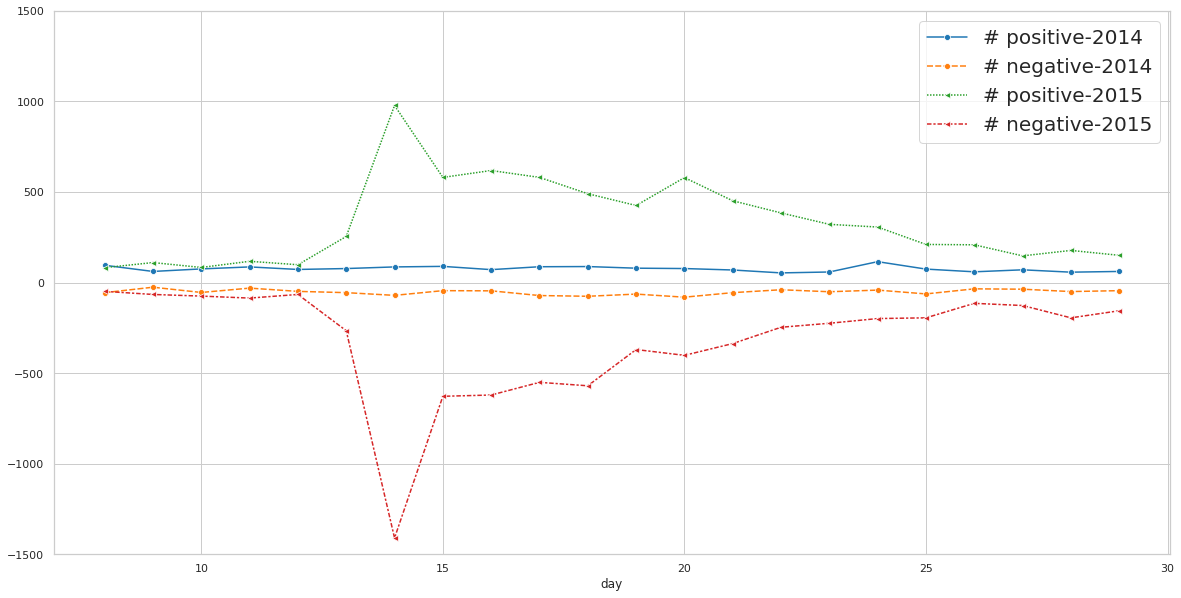

In [ ]:
# Graph 14 & 15
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (20, 10)
plt.ylim(-1500,1500)

sns.set_theme(style="whitegrid")
sns.lineplot(data=gd_14_15, palette="tab10", markers=["o","o","<","<"] )
plt.legend(labels=['# positive-2014', '# negative-2014','# positive-2015','# negative-2015'], fontsize=20)

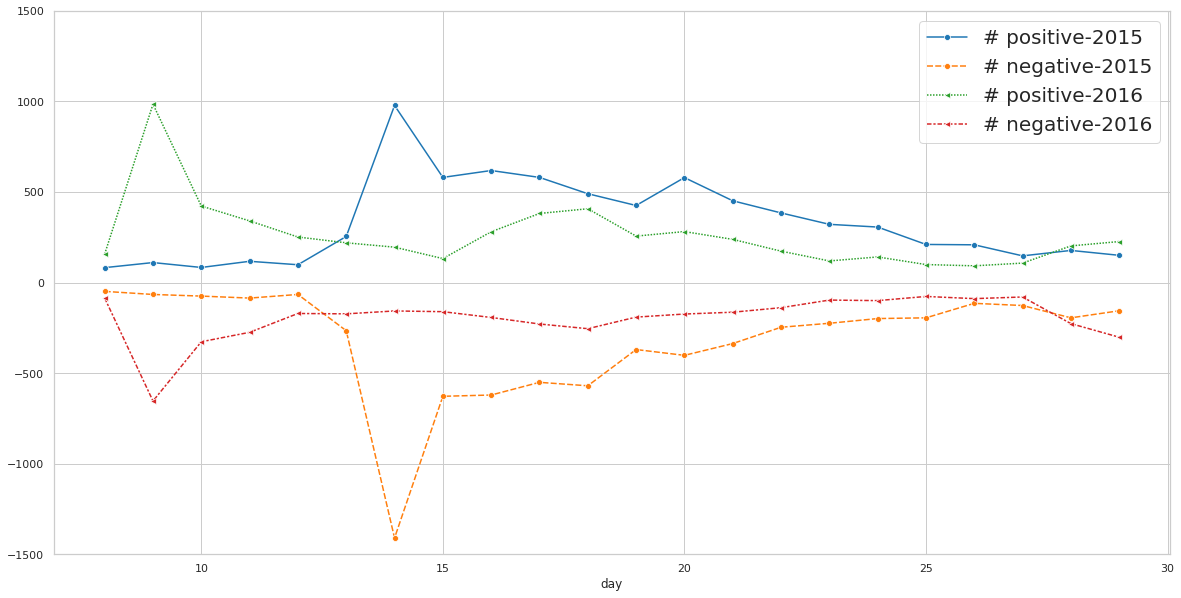

In [ ]:
# Graph 15 & 16
from matplotlib.font_manager import FontProperties
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = (20, 10)
plt.ylim(-1500,1500)
plt.rc('legend', fontsize=100)

sns.set_theme(style="whitegrid")
sns.lineplot(data=gd_15_16, palette="tab10", markers=["o","o","<","<"] )
plt.legend(labels=['# positive-2015', '# negative-2015','# positive-2016','# negative-2016'], fontsize=20)